# My own Machine Learning project
I have chosen the Sales predictions there are 6 datasets, some of these are only descriptive. I hope this will be a fun challenge for me, and that I will learn a lot during this project.
### Imports

In [34]:
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import zipfile
import os

from six.moves import urllib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### setup

#### DO this using kaggle API
Before you run this project, you need to download the order_products__prior.csv, this file was too large for GitHub even when compressed. And since you need a kaggle account to download the files, codes to do this only gave me permission denied. Therefore you'll need a kaggle account and this download link:
1. https://www.kaggle.com/c/instacart-market-basket-analysis/download/order_products__prior.csv

Then add it to the Datasets folder

In [35]:
%autosave 60
# uncompress set that was to big for GitHub uncompressed, but small enough when compressed
DATASETS_PATH = "Datasets"

# Function to fetch the data from url
def uncompress_orders(path=DATASETS_PATH):
    orders_path = os.path.join(path, "orders.csv.zip")
    orders_zip = zipfile.ZipFile(orders_path)
    orders_zip.extractall(path=path)
    orders_zip.close()
    

Autosaving every 60 seconds


In [36]:
uncompress_orders()

In [37]:
def load_set(csv_file):
    return pd.read_csv(os.path.join("Datasets", csv_file))

def load_all_sets():
    return (load_set("aisles.csv"), load_set("departments.csv"), load_set("order_products__prior.csv"),
            load_set("order_products__train.csv"), load_set("orders.csv"), load_set("products.csv"))

In [38]:
ailes, departments, prior_order, train_order, orders, products = load_all_sets()

What we have here is 6 datasets that are connected by id's, connecting these together will create too big of a dataset for my computer to handle, so we will have to do something clever here

## Discover and visualize the data
We will first create a brief overview of the data we have collected

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113ef3fd0>,
      dtype=object)

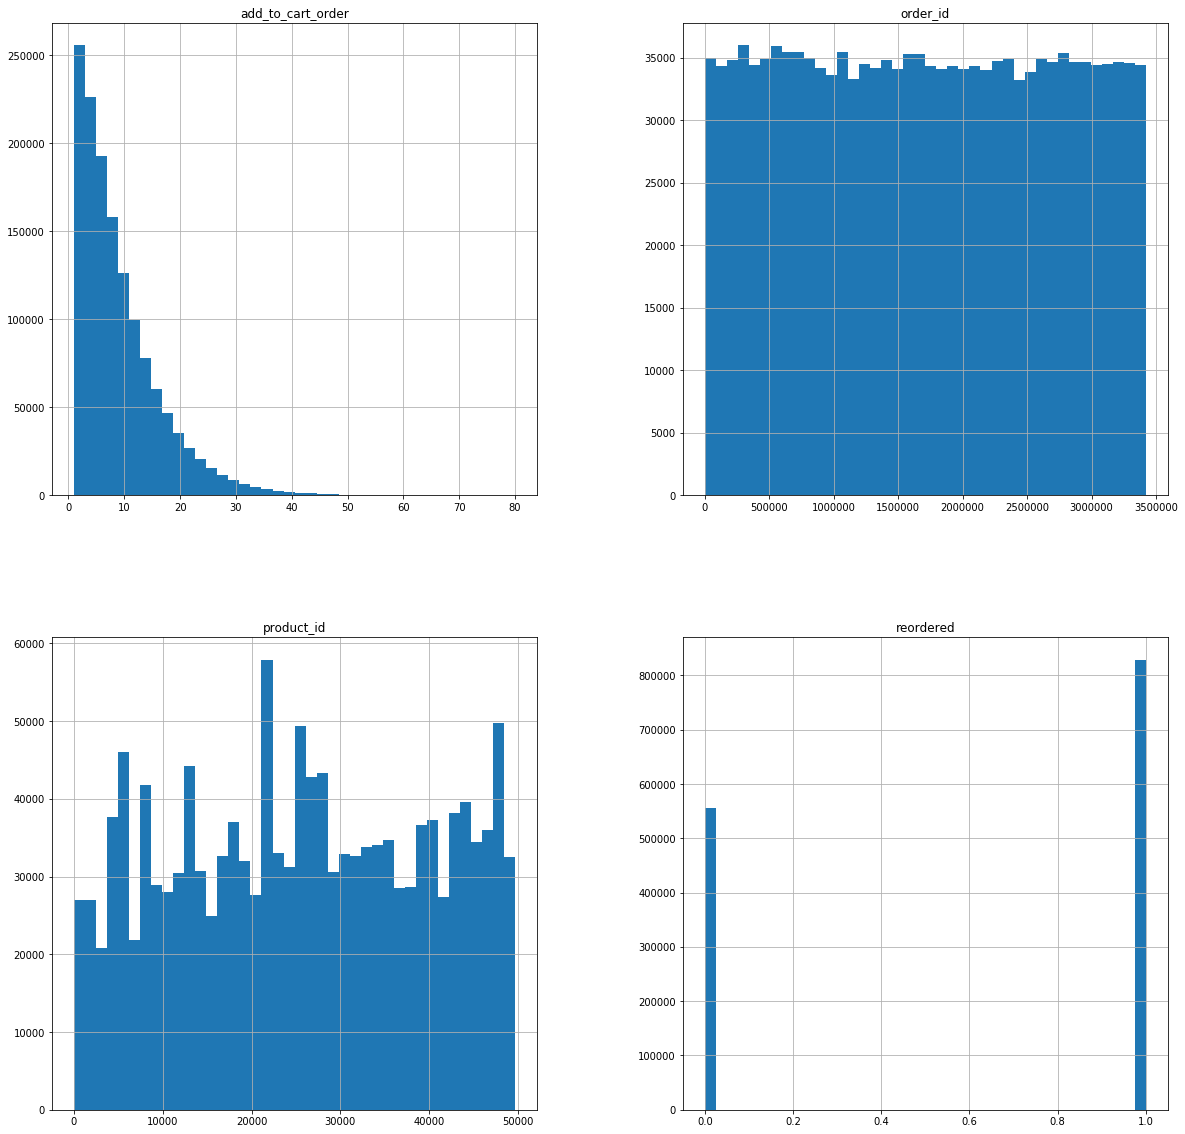

In [40]:
train_order.hist(bins=40, figsize=(20,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1146df860>,
      dtype=object)

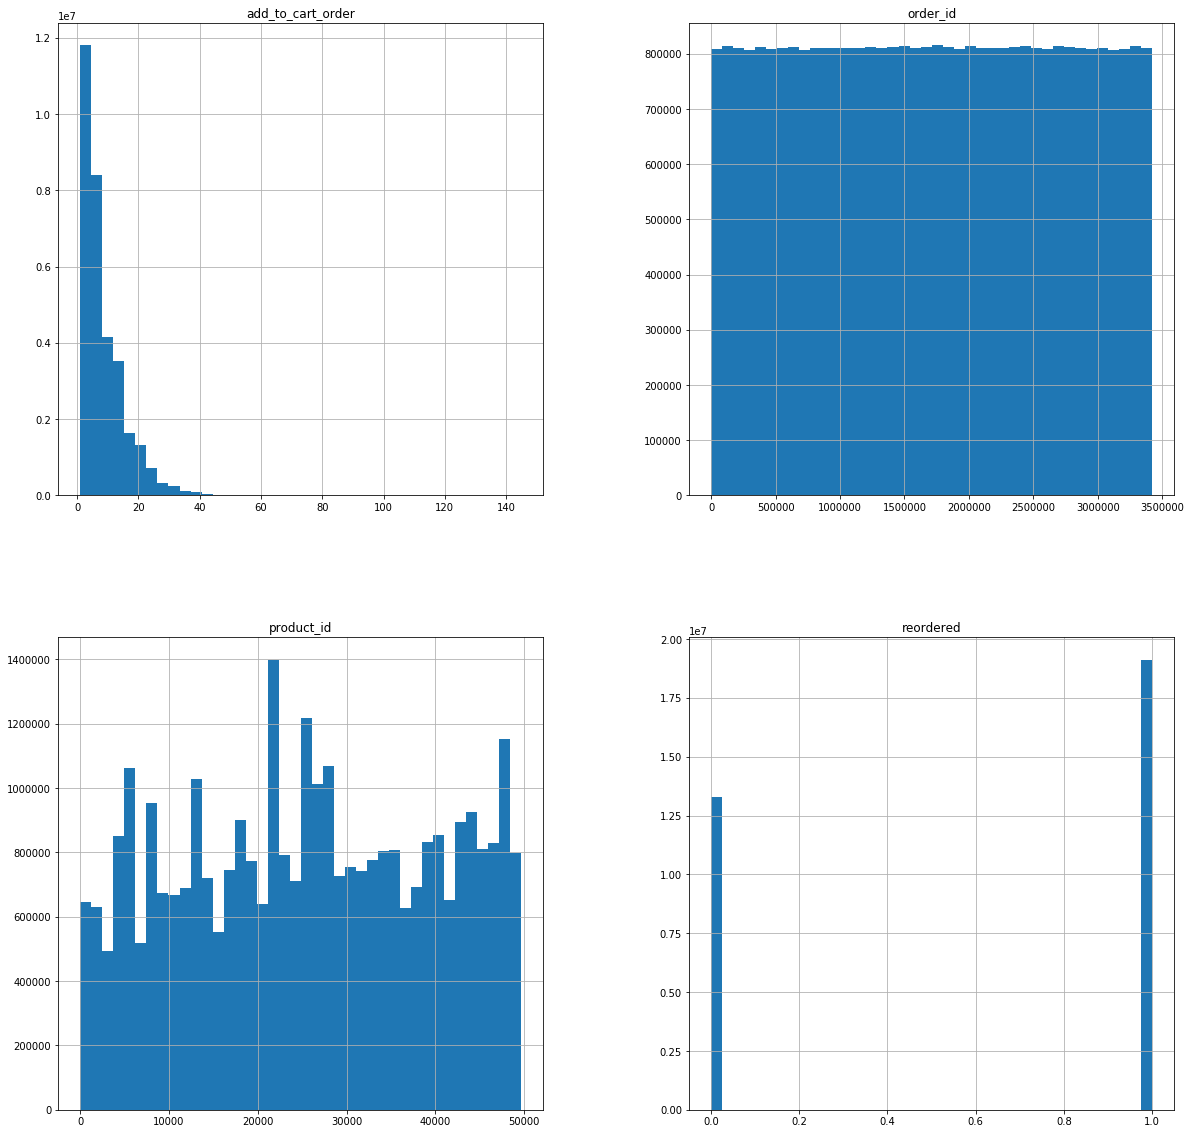

In [41]:
prior_order.hist(bins=40, figsize=(20,20))

Discover which departments that are most represented in the dataset.

# Du kan også prøve å combine alle 6 datasettene

In [42]:
full_set = pd.concat([train_order, prior_order])

In [43]:
full_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 1.3 GB


Add the user_id

In [45]:
full_set['user_id'] = 0

In [ ]:
for i in range(len(full_set)):
    full_set.iloc[i]
    usr_id = orders[orders['order_id'] == full_set.iloc[i, 0]]
    full_set['user_id'] = usr_id.iloc[0,1]

## Clean data
We will now clean the data, we do this to avoid unnecessary values. And also to check and remove nullvalues. Our goal is to have all the data that is interesting to the algorithm, no more, no less.

In [6]:
ailes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [7]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int64
department       21 non-null object
dtypes: int64(1), object(1)
memory usage: 416.0+ bytes


In [8]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [10]:
prior_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


In [11]:
train_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             1384617 non-null int64
product_id           1384617 non-null int64
add_to_cart_order    1384617 non-null int64
reordered            1384617 non-null int64
dtypes: int64(4)
memory usage: 42.3 MB


In [12]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [13]:
prior_order.describe()

,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


In [14]:
prior_order

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [15]:
train_order

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


After a quick look at the dataset I notice one thing
1. I think it is safe to remove the add_cart_to_order, since it is incrementing. So we can assume that the first item in the list is the first ordered, and the last element is the last ordered. But we should check if there is a single exception in the datasets.

In [16]:
# Figure out if there is an exception to the assumption above
def find_exceptions(order):
    index = 1
    nr_of_iterations = 1
    for i in order:
        if index > i:
            index = 1
            if index != i: 
                return ("Exception found at: number of iteration: ", nr_of_iterations,"Expected: ", index,"Got :" , i)
        elif index != i:
            return ("Exception found at: number of iteration: ", nr_of_iterations,"Expected: ", index,"Got :" , i)
        
        nr_of_iterations += 1
        index += 1
    return ("No exception where found")

In [17]:
find_exceptions(prior_order["add_to_cart_order"])

'No exception where found'

In [18]:
find_exceptions(train_order["add_to_cart_order"])

'No exception where found'

After seeing this I assume that the value of "add_to_cart_order" is irrelevant to the data so therefore I choose to remove it from the sets.

In [19]:
prior_order.drop("add_to_cart_order", axis=1, inplace=True)
prior_order.head()

,order_id,product_id,reordered
0,2,33120,1
1,2,28985,1
2,2,9327,0
3,2,45918,1
4,2,30035,0


In [20]:
train_order.drop("add_to_cart_order", axis=1, inplace=True)
train_order.head()

,order_id,product_id,reordered
0,1,49302,1
1,1,11109,1
2,1,10246,0
3,1,49683,0
4,1,43633,1


In [24]:
prior_order.isnull().sum().sum()

0

In [25]:
train_order.isnull().sum().sum()

0

There are no null values so we do not have to worry about that. Now we'll split the sets into train and test.

In [27]:
train_order_train, train_order_test = train_test_split(train_order, random_state=21)

In [28]:
train_order_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038462 entries, 1261648 to 202552
Data columns (total 3 columns):
order_id      1038462 non-null int64
product_id    1038462 non-null int64
reordered     1038462 non-null int64
dtypes: int64(3)
memory usage: 31.7 MB


In [29]:
train_order_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346155 entries, 181932 to 1279369
Data columns (total 3 columns):
order_id      346155 non-null int64
product_id    346155 non-null int64
reordered     346155 non-null int64
dtypes: int64(3)
memory usage: 10.6 MB
